In [27]:
# packages

import pathlib
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))


In [46]:
# functions

def compute_transform_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    
    return position

def compute_tower_radius(x):

    if x <= H:
        a = a0
    else:
        a = 0
    
    return a


# interpolate airfoil (provided in course materials)

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
fstat_tab=np.zeros([105,6])
Cl_inv_tab=np.zeros([105,6])
Cl_fs_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],fstat_tab[:,i],Cl_inv_tab[:,i],Cl_fs_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    fstat_aoa=np.zeros([1,6])
    Cl_inv_aoa=np.zeros([1,6])
    Cl_fs_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
        fstat_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,fstat_tab[:,i])
        Cl_inv_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_inv_tab[:,i])
        Cl_fs_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_fs_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    fstat=np.interp (thick,thick_prof,fstat_aoa[0,:])
    cl_inv=np.interp (thick,thick_prof,Cl_inv_aoa[0,:])
    cl_fs=np.interp (thick,thick_prof,Cl_fs_aoa[0,:])

    return cl, cd, cm , fstat, cl_inv, cl_fs



# BEM
def aeroelasticity(t_total=10, dt=0.1, V0=10, turb=False, theta_pitch=0, omega=1, control = False, M_matrix = np.zeros((3,3)), C_matrix=np.zeros((3,3)), K_matrix=np.zeros((3,3))):
    num = int(t_total / dt)+1 # number of time steps

    # creating empty arrays to store values
    time = np.zeros(num)
    
    P = np.zeros((num,B))
    T = np.zeros((num,B))
    
    Wy = np.zeros((B,len(r_array)))
    Wz = np.zeros((B,len(r_array)))

    Wy_int = np.zeros((B,len(r_array)))
    Wz_int = np.zeros((B,len(r_array)))

    Wy_qs = np.zeros((B,len(r_array)))
    Wz_qs = np.zeros((B,len(r_array)))

    fs_matrix = np.zeros((B,len(r_array)))

    theta_pitch_array = np.zeros(num) + theta_pitch
    omega_array = np.zeros(num) + omega

    x_array = np.zeros((num,len(M_matrix)))
    dx_array = np.zeros((num,len(M_matrix)))
    ddx_array = np.zeros((num,len(M_matrix)))

    GF_array = np.zeros((num,len(M_matrix)))

    u_array = np.zeros((num,B,len(r_array),2))
    du_array = np.zeros((num,B,len(r_array),2))
    ddu_array = np.zeros((num,B,len(r_array),2))


    # initial conditions
    theta_blade1_old = 0 # initial position of blade 1 [rad]
    theta_I = theta_pitch # initial integral term of controller
    
    ddx = np.linalg.inv(M_matrix) @ (GF_array[0,:] - C_matrix@dx_array[0,:] - K_matrix@x_array[0,:])


    # time step iteration
    for n in range(num):

        # simulation time [s]
        time[n] = n*dt

        '''
        ##########       BEM       ##########
        '''

        # blade positions [rad]
        theta_blade1 = theta_blade1_old + omega*dt
        theta_blade2 = theta_blade1 + 2*np.pi/B
        theta_blade3 = theta_blade2 + 2*np.pi/B

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        # empty arrays for storing P and T for all blades in current time step
        P_inst = np.zeros(B)
        T_inst = np.zeros(B)

        py_array = np.zeros((B,len(r_array)))
        pz_array = np.zeros((B,len(r_array)))


        # blades iteration
        for j in range(B):

            # calculate transformation matrices for current blade position
            a21, a23, a41 = compute_transform_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            # empty arrays for storing dP, dT for each segment
            dP_array = np.zeros(len(r_array))
            dT_array = np.zeros(len(r_array))

            
            # blade segment iteration
            for i in range(len(r_array)):
                # parameters of the segment
                r = r_array[i] # radius [m]
                beta = beta_array[i] # twist angle [rad]
                c = c_array[i] # chord length [m]
                thick_perc = t_perc_array[i] # thickness ratio of blade [%]
                
                # segment position in CS1
                r_1_vec = compute_position(a21, a41, H, Ls, r)

                # wind speed of segment based on wind shear
                V0x = V0*(r_1_vec[0] / H)**nu

                # tower model calculations
                y = r_1_vec[1]
                z = r_1_vec[2]
                r_1 = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1_vec[0]) # tower radius at current height [m]

                Vr =     z/r_1 * V0x * (1 - (a_tower/r_1)**2)
                Vtheta = y/r_1 * V0x * (1 + (a_tower/r_1)**2)

                if turb == True:
                    # calculating the fluctuating component (interpolation)
                    f_u = interp2d(y_sample, x_sample, fluc_x[n])
                    f_v = interp2d(y_sample, x_sample, fluc_y[n])
                    f_w = interp2d(y_sample, x_sample, fluc_z[n])

                    # final wind components in CS1 [m/s]
                    Vx = float(0 + f_u(y, z))
                    Vy = float(y/r_1 * Vr - z/r_1 * Vtheta + f_v(y, z))
                    Vz = float(z/r_1 * Vr + y/r_1 * Vtheta + f_w(y, z))
                else:
                    # final wind components in CS1 [m/s]
                    Vx = 0
                    Vy = y/r_1 * Vr - z/r_1 * Vtheta
                    Vz = z/r_1 * Vr + y/r_1 * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1 = [Vx, Vy, Vz] # wind speed in CS1 [m/s]
                V0_4 = np.matmul(a14, np.transpose(V0_1)) # wind speed in CS4 [m/s]
                V0_magn = np.linalg.norm(V0_4) # magnitude of local wind considering wind shear and tower effect
                
                # relative wind speeds (CS4) [m/s]
                Vrel_y = V0_4[1] + Wy[j,i] - omega*r*np.cos(theta_cone) - du_array[n-1,j,i,0] # tangential
                Vrel_z = V0_4[2] + Wz[j,i] - du_array[n-1,j,i,1] # normal
                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2) # magnitude

                phi = np.arctan(- Vrel_z/Vrel_y) # flow angle [rad]
                alpha = phi - (beta + theta_pitch) # angle of attack [rad]

                # lift and drag coefficients
                fs_old = fs_matrix[j,i]
                Cl, Cd, Cm, fstat, Cl_inv, Cl_fs = force_coeffs_10MW(np.rad2deg(alpha),thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab)
                tau = 4 * c / Vrel
                fs = fstat + (fs_old - fstat) * np.exp(-dt/tau)
                Cl = fs * Cl_inv + (1-fs) * Cl_fs

                fs_matrix[j,i] = fs
                
                # induction factor and Glauert correction
                a = - Wz[j,i] / V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)
                
                # Prandtl tip loss correction
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                # lift and drag forces [N/m]
                l = 0.5*rho*Vrel**2 * c * Cl # lift
                d = 0.5*rho*Vrel**2 * c * Cd # drag

                # normal and tangential loads [N/m]
                pz = l*np.cos(phi) + d*np.sin(phi) # normal
                py = l*np.sin(phi) - d*np.cos(phi) # tangential

                # quasi-steady induced wind
                Wy_qs_new = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[j,i])**2))
                Wz_qs_new = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[j,i])**2))

                # updating induced wind with DYNAMIC WAKE
                k = 0.6
                tau_1 = 1.1/(1-1.3*a) * R/V0  #time constant 1
                tau_2 = (0.39-0.26 * (r/R)**2) * tau_1 #time constant 2

                RHS_y = Wy_qs_new + k * tau_1 * (Wy_qs_new - Wy_qs[j,i]) / dt
                Wy_int[j,i] = RHS_y + (Wy_int[j,i] - RHS_y) * np.exp(-dt/tau_1)
                Wy[j,i] = Wy_int[j,i] + (Wy[j,i] - Wy_int[j,i]) * np.exp(-dt/tau_2)

                RHS_z = Wz_qs_new + k * tau_1 * (Wz_qs_new - Wz_qs[j,i]) / dt
                Wz_int[j,i] = RHS_z + (Wz_int[j,i] - RHS_z) * np.exp(-dt/tau_1)
                Wz[j,i] = Wz_int[j,i] + (Wz[j,i] - Wz_int[j,i]) * np.exp(-dt/tau_2)

                # ### KILLING THE DYNAMIC WAKE MODEL (for faster convergence)
                # Wy[j,i] = Wy_qs_new
                # Wz[j,i] = Wz_qs_new  
                
                Wy_qs[j,i] = Wy_qs_new
                Wz_qs[j,i] = Wz_qs_new

                # power and thrust of segment
                dP = omega*py*r # power
                dT = pz # thrust

                dP_array[i] = dP
                dT_array[i] = dT

                py_array[j,i] = py
                pz_array[j,i] = pz

            # integrating segment values to get P and T per blade
            P_blade = integrate.simpson(y=dP_array, x=r_array)
            T_blade = integrate.simpson(y=dT_array, x=r_array)
            
            P_inst[j] = P_blade
            T_inst[j] = T_blade

        # updating blade location
        theta_blade1_old = theta_blade1

        P[n,:] = P_inst
        T[n,:] = T_inst

        if omega > omega_rated:
            M_g = P_rated / omega_rated
        else:
            M_g = K * omega**2
        
        '''
        ########## STRUCTURAL ##########
        '''

        u1f_Ry_array = u1fz_array*np.sin(theta_pitch) + u1fy_array*np.cos(theta_pitch)
        u1f_Rz_array = u1fz_array*np.cos(theta_pitch) - u1fy_array*np.sin(theta_pitch)
        u1e_Ry_array = u1ez_array*np.sin(theta_pitch) + u1ey_array*np.cos(theta_pitch)
        u1e_Rz_array = u1ez_array*np.cos(theta_pitch) - u1ey_array*np.sin(theta_pitch)
        u2f_Ry_array = u2fz_array*np.sin(theta_pitch) + u2fy_array*np.cos(theta_pitch)
        u2f_Rz_array = u2fz_array*np.cos(theta_pitch) - u2fy_array*np.sin(theta_pitch)

        u1f_R_array = np.array([u1f_Ry_array, u1f_Rz_array]).T
        u1e_R_array = np.array([u1e_Ry_array, u1e_Rz_array]).T
        u2f_R_array = np.array([u2f_Ry_array, u2f_Rz_array]).T 

        # prediction
        ddx_up = ddx_array[n-1,:]
        dx_up = dx_array[n-1,:] + dt*ddx_array[n-1,:]
        x_up = x_array[n-1,:] + dt*dx_array[n-1,:] + 0.5*dt**2 * ddx_array[n-1,:]

        # print(n-1, dx_array[n-1,:])
        GF1 = sum(T[n])
        GF2 = sum(P[n])/omega - M_g
        GF3 = integrate.simpson(y=py_array[0,:]*u1f_Ry_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1f_Rz_array, x=r_array)
        GF4 = integrate.simpson(y=py_array[0,:]*u1e_Ry_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1e_Rz_array, x=r_array)
        GF5 = integrate.simpson(y=py_array[0,:]*u2f_Ry_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u2f_Rz_array, x=r_array)
        
        if len(M_matrix)==5:
            GF = np.array([GF1, GF2, GF3, GF4, GF5])
        elif len(M_matrix)==3:
            GF = np.array([GF3, GF4, GF5])
        GF_array[n,:] = GF

        check = 0
        step = 0

        while check==0:

            # step 3
            residual = GF - M_matrix@ddx_up - C_matrix@dx_up - K_matrix@x_up
            # print("residual is ",residual)
            r_max = np.max(np.abs(residual))
            print("r_max is ",r_max)

            # step 4
            K_eff = K_matrix + (Newmark_gamma / (Newmark_beta*dt))*C_matrix + (1/(Newmark_beta*dt**2))*M_matrix
            delta_x = np.linalg.inv(K_eff) @ residual
            
            x_up = x_up + delta_x
            dx_up  = dx_up + (Newmark_gamma/(Newmark_beta*dt))*delta_x
            ddx_up = ddx_up + (1/(Newmark_beta*dt**2))*delta_x

            step += 1
            if r_max < eps:
                check = 1
                print(f'condition reached at {step} steps')
            if step > step_max:
                check = 1
                print('max cunt reached')
                
        
        ddx_array[n,:] = ddx_up
        dx_array[n,:] = dx_up
        x_array[n,:] = x_up   

        for i in range(len(r_array)):
            u_array[n,0,i,:] = x_up[-3]*u1f_R_array[i,:] + x_up[-2]*u1e_R_array[i,:] + x_up[-1]*u2f_R_array[i,:]
            du_array[n,0,i,:] = dx_up[-3]*u1f_R_array[i,:] + dx_up[-2]*u1e_R_array[i,:] + dx_up[-1]*u2f_R_array[i,:]
            ddu_array[n,0,i,:] = ddx_up[-3]*u1f_R_array[i,:] + ddx_up[-2]*u1e_R_array[i,:] + ddx_up[-1]*u2f_R_array[i,:]

        dtheta = dx_up[1]

            
        # ########## CONTROL ##########
        if control:

            omega, theta_pitch, theta_I = controller(omega, theta_pitch, P, theta_I, dt, n, M_g, dtheta=dtheta)
            omega_array[n] = omega
            theta_pitch_array[n] = theta_pitch

        print("Time is: "+ str(time[n]) + " s")


    solution = {
    'dt': dt,
    'time': time,
    'P': P,
    'T': T,
    'pt': py_array,
    'pn': pz_array,
    'omega': omega_array,
    'theta_pitch': theta_pitch_array,
    "x_array": x_array,
    "dx_array": dx_array,
    "ddx_array": ddx_array,
    "GF_array": GF_array,
    "u_array": u_array,
    "du_array": du_array,
    "ddu_array": ddu_array
    }

    return solution


def load(filename, N=(32, 32)):

    data = np.fromfile(filename, np.dtype('<f'), -1)
    if len(N) == 2:
        ny, nz = N
        nx = len(data) / (ny * nz)
        assert nx == int(nx), "Size of turbulence box (%d) does not match ny x nz (%d), nx=%.2f" % (
            len(data), ny * nz, nx)
        nx = int(nx)
    else:
        nx, ny, nz = N
        assert len(data) == nx * ny * \
            nz, "Size of turbulence box (%d) does not match nx x ny x nz (%d)" % (len(data), nx * ny * nz)
    return data.reshape(nx, ny * nz)

def controller(omega, theta_pitch, P_per_blade, theta_I_prev, dt, time_step_num, M_g, dtheta = None):

    GK = 1/(1+theta_pitch/K1)
    theta_P = GK * Kp * (omega - omega_ref)
    theta_I = theta_I_prev +  GK * Ki * (omega - omega_ref) * dt
    theta_sp = theta_P + theta_I
        
    if theta_sp > theta_pitch + dtheta_pitch * dt:
        theta_sp = theta_pitch + dtheta_pitch * dt
    elif theta_sp < theta_pitch - dtheta_pitch * dt:
        theta_sp = theta_pitch - dtheta_pitch * dt

    if theta_sp > theta_pitch_max:
        theta_sp = theta_pitch_max
    elif theta_sp < theta_pitch_min:
        theta_sp = theta_pitch_min

    theta_pitch = theta_sp
    M_aero = sum(P_per_blade[time_step_num])/omega
    if dtheta:
        omega = dtheta
    else:
        omega = omega + (M_aero - M_g)/I * dt
        

    return omega, theta_pitch, theta_I


In [29]:
# READ DATA

# blade geometry
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# mode shapes
modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])
new_row = pd.DataFrame({'r': [2.8000], 'u1fy': [0], 'u1fz': [0], 'u1ey': [0], 'u1ez': [0], 'u2fy': [0], 'u2fz': [0], 'm': [1189.51],}) 
modeshape = pd.concat([new_row, modeshape]).reset_index(drop=True)

u1fy_array = modeshape['u1fy']
u1fz_array = modeshape['u1fz']
u1ey_array = modeshape['u1ey']
u1ez_array = modeshape['u1ez']
u2fy_array = modeshape['u2fy']
u2fz_array = modeshape['u2fz']
m_array = modeshape['m']

u1f_array = np.array([u1fy_array, u1fz_array]).T
u1e_array = np.array([u1ey_array, u1ez_array]).T
u2f_array = np.array([u2fy_array, u2fz_array]).T

omega1f=3.93
omega1e=6.10
omega2f=11.28

print(u1f_array.shape)

(18, 2)


C:\Users\s232055\AppData\Local\Temp\ipykernel_7708\2412070034.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])


In [52]:
# DATA GLOBAL

# # TIME SIMULATION PARAMETERS
# t_total = 100
# dt = 0.1 # time step size [s]
# num = int(t_total / dt)+1 # number of time steps

# NEWMARK COVERGENCE PARAMETERS
eps = 1e-3
step_max = 100


# GEOMETRIC PARAMETERS
B = 3 # number of blades
R = 89.17 # rotor diameter [m]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m] 

rho = 1.225 # air density [kg/m3]

# wind
nu = 0.0 # wind shear exponent
# V0 = 8 # mean wind speed at hub height [m/s]

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]


# CONTROL
Ki = 0.64 #radians
Kp = 1.5 #radians
K1 = np.deg2rad(14)
I = 1.6e8
theta_pitch_min = 0
theta_pitch_max = np.deg2rad(45)
dtheta_pitch = np.deg2rad(9) #rad/s
omega_rated = 1.02265
omega_ref = 1.01 * omega_rated
P_rated = 10.64e6
lam = 8
c_P = 0.4662 #c_p optimal
K = 0.5 * rho * np.pi*R**2 * R**3 * c_P/lam**3
V_rated = (R*omega_rated)/lam


# STRUCTURAL
k_spring = 1.7e6
mass = 446e3
delta = 0.03
Newmark_beta = 0.27
Newmark_gamma = 0.51

GM1 = integrate.simpson(y=u1fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u1fz_array**2 * m_array , x=r_array)
GM2 = integrate.simpson(y=u1ey_array**2 * m_array , x=r_array) + integrate.simpson(y=u1ez_array**2 * m_array , x=r_array)
GM3 = integrate.simpson(y=u2fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u2fz_array**2 * m_array , x=r_array)

M3_matrix = np.zeros((3,3))
M3_matrix[0,0] = GM1
M3_matrix[1,1] = GM2
M3_matrix[2,2] = GM3

K3_matrix = np.zeros((3,3))
K3_matrix[0,0] = GM1*omega1f**2
K3_matrix[1,1] = GM2*omega1e**2
K3_matrix[2,2] = GM3*omega2f**2

C3_matrix = np.zeros((3,3))
# C_matrix[0,0] = GM1*omega1f*delta/np.pi
# C_matrix[1,1] = GM2*omega1e*delta/np.pi
# C_matrix[2,2] = GM3*omega2f*delta/np.pi


In [31]:
# test
solu = aeroelasticity(t_total=300, dt=0.1, V0=7, omega=0.628, theta_pitch=0, M_matrix = M3_matrix, C_matrix = C3_matrix, K_matrix = K3_matrix)

r_max is  79434.01850829022
r_max is  2.2737367544323206e-12
condition reached at 2 steps
Time is: 0.0 s
r_max is  16065.387222324944
r_max is  1.8189894035458565e-12
condition reached at 2 steps
Time is: 0.1 s
r_max is  42533.55517287615
r_max is  7.275957614183426e-12
condition reached at 2 steps
Time is: 0.2 s
r_max is  35373.12050800024
r_max is  0.0
condition reached at 2 steps
Time is: 0.30000000000000004 s
r_max is  28367.687475103074
r_max is  3.637978807091713e-12
condition reached at 2 steps
Time is: 0.4 s
r_max is  11696.104120717946
r_max is  3.637978807091713e-12
condition reached at 2 steps
Time is: 0.5 s
r_max is  18054.22154283559
r_max is  5.4569682106375694e-12
condition reached at 2 steps
Time is: 0.6000000000000001 s
r_max is  24749.185129991623
r_max is  1.4551915228366852e-11
condition reached at 2 steps
Time is: 0.7000000000000001 s
r_max is  16575.086729763396
r_max is  1.4551915228366852e-11
condition reached at 2 steps
Time is: 0.8 s
r_max is  16909.7126427156

dict_keys(['dt', 'time', 'P', 'T', 'pt', 'pn', 'omega', 'theta_pitch', 'x_array', 'dx_array', 'ddx_array', 'GF_array', 'u_array', 'du_array', 'ddu_array']) (3001,) (3001, 3)
(3001, 3)


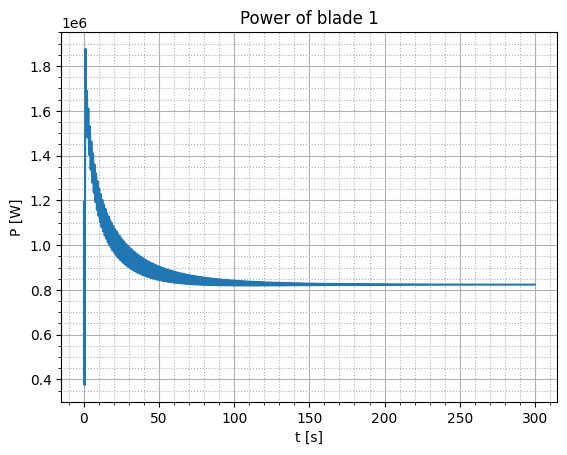

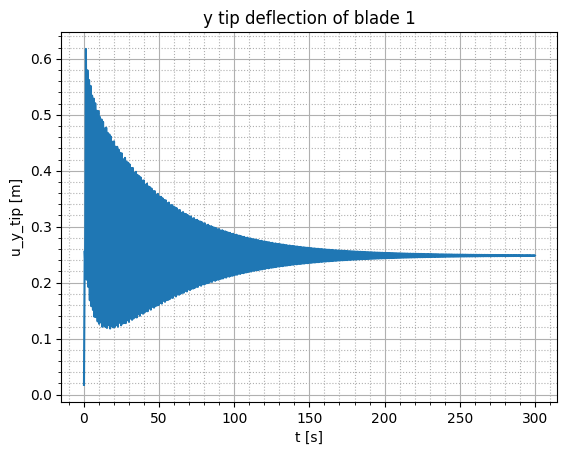

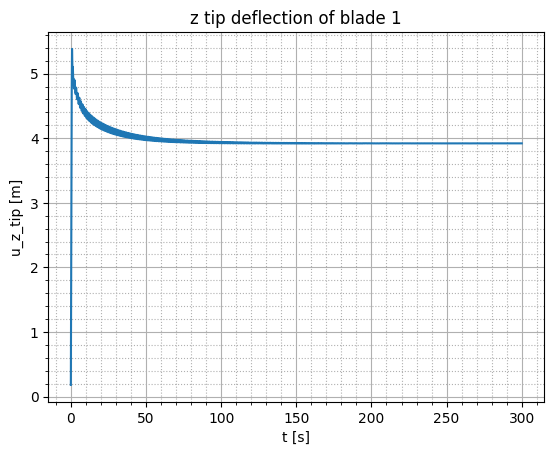

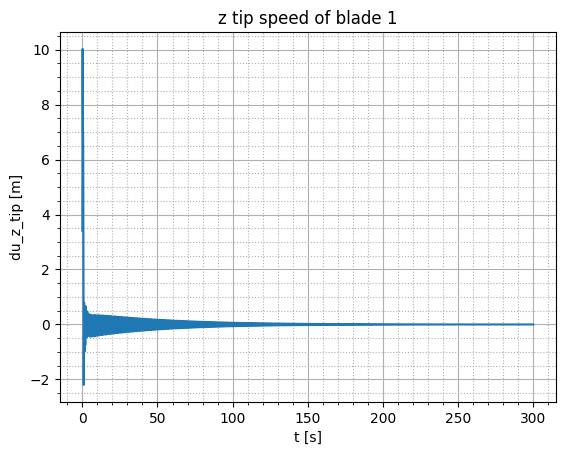

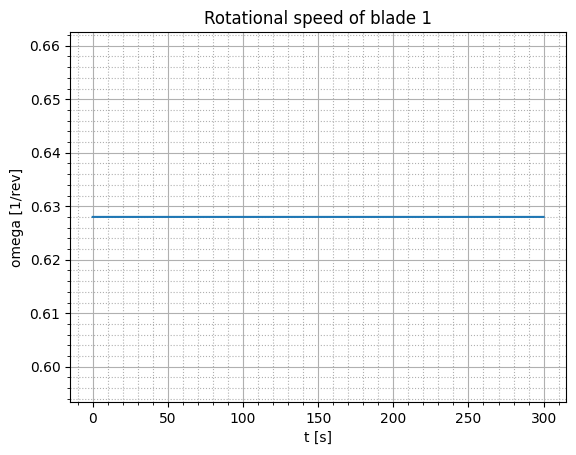

In [32]:
print(solu.keys(), solu['time'].shape, solu['x_array'].shape)
print(solu['x_array'].shape)

fig, ax = plt.subplots()
ax.plot(solu['time'], solu["P"][:,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('P [W]')
ax.set_title('Power of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_P_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu['time'], solu['u_array'][:,0,-1,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1.png", dpi=600)

# plt.figure()
# plt.plot(r_array, solu['u_array'][-1,0,:,0])
# plt.xlabel('r [m]')
# plt.ylabel('u_y [m]')
# plt.title('y deflection of blade 1 at last time step')
# plt.show()

fig, ax = plt.subplots()
ax.plot(solu['time'], solu['u_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_z_tip [m]')
ax.set_title('z tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uz_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu['time'], solu['du_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('du_z_tip [m]')
ax.set_title('z tip speed of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines

# plt.figure()
# plt.plot(r_array, solu['u_array'][-1,0,:,1])
# plt.xlabel('r [m]')
# plt.ylabel('u_z [m]')
# plt.title('z deflection of blade 1 at last time step')
# plt.show()



fig, ax = plt.subplots()
ax.plot(solu['time'], solu["omega"])
ax.set_xlabel('t [s]')
ax.set_ylabel('omega [1/rev]')
ax.set_title('Rotational speed of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_omega_blade1.png", dpi=600)


# skip = 1
# cut = 10
# speed = 1

# fig, ax = plt.subplots()
# line = ax.plot(r_array, solu['u_array'][0,0,:,0])[0]
# ax.set(xlim=[min(r_array), max(r_array)], ylim=[np.min(solu['u_array'][:,0,:,0]), np.max(solu['u_array'][:,0,:,0])])
# ax.set_xlabel('r [m]')
# ax.set_ylabel('u_y [m]')
# ax.set_title('y deflection of blade 1')

# time_text = ax.text(0.95, 0.95, 'Time: {:.2f} s'.format(solu["time"][0]), transform=ax.transAxes, ha='right', va='top')

# def update(frame):
#     # line.set_xdata(r_array)
#     line.set_ydata(solu['u_array'][frame*skip,0,:,0])

#     time_text.set_text('Time: {:.2f} s'.format(solu["time"][frame*skip]))
#     return line

# ani = animation.FuncAnimation(fig=fig, func=update, frames=m.floor(len(solu['u_array'][:,0,0,0])/skip/cut), interval=solu["dt"]*1000*skip/speed)
# ani.save("A3_Q1_uy_anim.gif")


# fig, ax = plt.subplots()
# line = ax.plot(r_array, solu['u_array'][0,0,:,1])[0]
# ax.set(xlim=[min(r_array), max(r_array)], ylim=[np.min(solu['u_array'][:,0,:,1]), np.max(solu['u_array'][:,0,:,1])])
# ax.set_xlabel('r [m]')
# ax.set_ylabel('u_z [m]')
# ax.set_title('z deflection of blade 1')

# time_text = ax.text(0.95, 0.95, 'Time: {:.2f} s'.format(solu["time"][0]), transform=ax.transAxes, ha='right', va='top')

# def update(frame):
#     # line.set_xdata(r_array)
#     line.set_ydata(solu['u_array'][frame*skip,0,:,1])

#     time_text.set_text('Time: {:.2f} s'.format(solu["time"][frame*skip]))
#     return line

# ani = animation.FuncAnimation(fig=fig, func=update, frames=m.floor(len(solu['u_array'][:,0,0,1])/skip/cut), interval=solu["dt"]*1000*skip/speed)
# ani.save("A3_Q1_uz_anim.gif")

In [33]:
## Q1 TURBULENCE

umean = 7

n1=4096
n2=32
n3=32

Lx=409.5 *umean
Ly=180
Lz=180

deltay=Ly/(n2-1)
deltax=Lx/(n1-1)
deltaz=Lz/(n3-1)
deltat=deltax/umean

print(deltat)

ushp_all = []

for j in range(1,4):
    
    file = os.path.join(os.pardir, "sim_files", "sim"+str(j)+"_"+str(umean)+"_"+str(round(deltat/0.01)*0.01)+".bin")
    # file = "sim"+str(j)+"_"+str(i)+".bin"

    # Load in the files and reshape them into 3D
    u = load(file,  N=(n1, n2, n3))
    ushp = np.reshape(u, (n1, n2, n3))
    ushp_all.append(ushp)

# fluctuations in CS1
fluc_z = ushp_all[0]
fluc_y = - ushp_all[1]
fluc_x = ushp_all[2]

y_sample = ( np.arange(0, Ly+deltay, deltay) - (Ly/2) ) * (-1)
x_sample = np.arange(0, Lz+deltaz, deltaz) - (Lz/2) + H

solu_turb = aeroelasticity(turb=True, t_total=300, dt=deltat, V0=umean, omega=0.628, theta_pitch=0,M_matrix = M3_matrix, C_matrix = C3_matrix, K_matrix = K3_matrix)

0.09999999999999999
r_max is  76815.04461281511
r_max is  1.546140993013978e-11
condition reached at 2 steps
Time is: 0.0 s
r_max is  15875.680458039402
r_max is  1.8189894035458565e-12
condition reached at 2 steps
Time is: 0.09999999999999999 s
r_max is  40268.671524357764
r_max is  4.547473508864641e-13
condition reached at 2 steps
Time is: 0.19999999999999998 s
r_max is  34850.898812441716
r_max is  1.4551915228366852e-11
condition reached at 2 steps
Time is: 0.3 s


C:\Users\s232055\AppData\Local\Temp\ipykernel_7708\689580436.py:208: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_u = interp2d(y_sample, x_sample, fluc_x[n])
C:\Users\s232055\AppData\Local\Temp\ipykernel_7708\689580436.py:209: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` inst

r_max is  27942.68051146855
r_max is  3.637978807091713e-12
condition reached at 2 steps
Time is: 0.39999999999999997 s
r_max is  13627.775966771378
r_max is  3.637978807091713e-12
condition reached at 2 steps
Time is: 0.49999999999999994 s
r_max is  18479.255466688857
r_max is  1.4551915228366852e-11
condition reached at 2 steps
Time is: 0.6 s
r_max is  24889.672283623167
r_max is  9.094947017729282e-13
condition reached at 2 steps
Time is: 0.7 s
r_max is  17348.200087244928
r_max is  3.637978807091713e-12
condition reached at 2 steps
Time is: 0.7999999999999999 s
r_max is  18302.401922631994
r_max is  1.4551915228366852e-11
condition reached at 2 steps
Time is: 0.8999999999999999 s
r_max is  12997.447233312763
r_max is  9.094947017729282e-13
condition reached at 2 steps
Time is: 0.9999999999999999 s
r_max is  9448.135069103979
r_max is  1.4551915228366852e-11
condition reached at 2 steps
Time is: 1.0999999999999999 s
r_max is  12888.596842848145
r_max is  0.0
condition reached at 2 s

c:\Users\s232055\OneDrive\Asztali gép\Python\myenv\Lib\site-packages\scipy\signal\_spectral_py.py:589: UserWarning: nperseg = 1000000 is greater than input length  = 1001, using nperseg = 1001
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


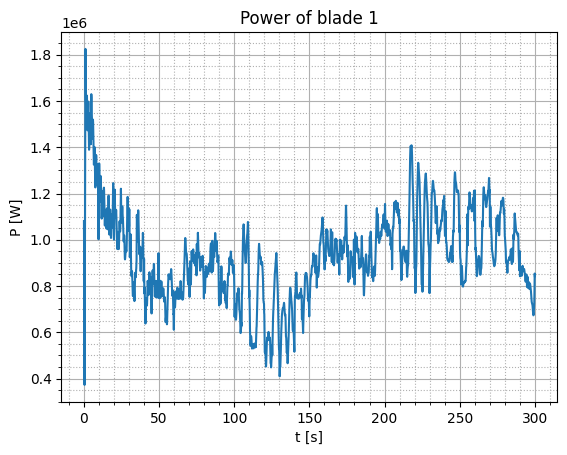

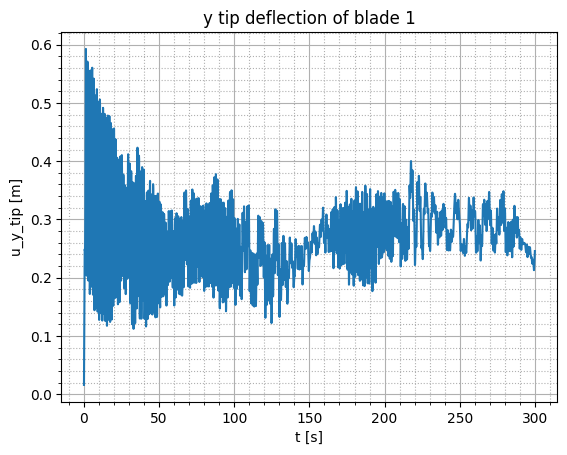

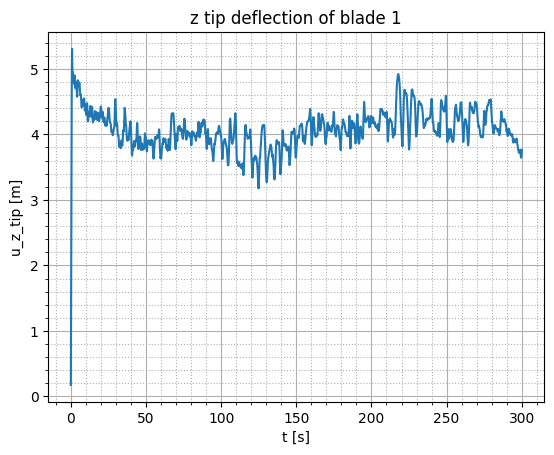

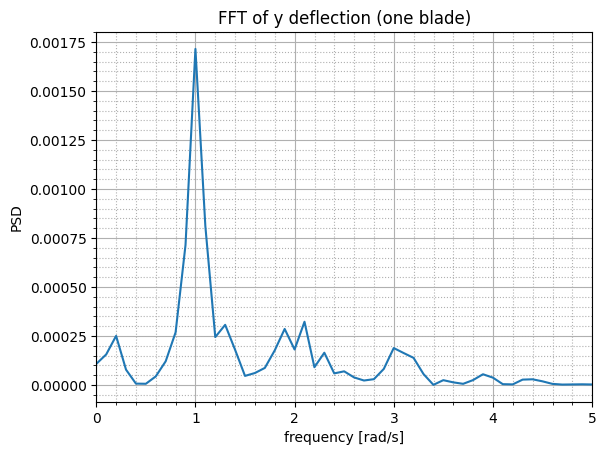

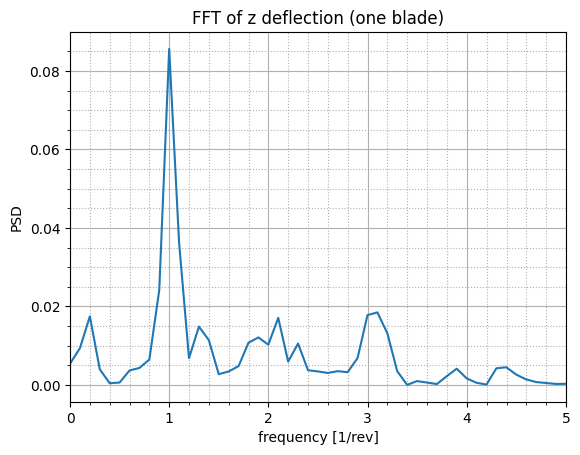

In [34]:
## Q1 TURBULENCE PLOTS

fig, ax = plt.subplots()
ax.plot(solu_turb['time'], solu_turb["P"][:,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('P [W]')
ax.set_title('Power of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_P_blade1_turb.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_turb['time'], solu_turb['u_array'][:,0,-1,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1_turb.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_turb['time'], solu_turb['u_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_z_tip [m]')
ax.set_title('z tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uz_blade1_turb.png", dpi=600)

f, Pxx_den = signal.welch(solu_turb['u_array'][2000:,0,-1,0], fs = 2*np.pi/solu_turb["dt"]/solu_turb["omega"][-1], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.plot(f, Pxx_den, "-")
ax.set_xlabel('frequency [rad/s]')
ax.set_ylabel('PSD')
ax.set_title("FFT of y deflection (one blade)")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 5)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uy_FFT", dpi=600)

f, Pxx_den = signal.welch(solu_turb['u_array'][2000:,0,-1,1], fs = 2*np.pi/solu_turb["dt"]/solu_turb["omega"][-1], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.plot(f, Pxx_den, "-")
ax.set_xlabel('frequency [1/rev]')
ax.set_ylabel('PSD')
ax.set_title("FFT of z deflection (one blade)")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 5)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uz_FFT", dpi=600)

In [70]:
## Q2

muz1f = integrate.simpson(y=m_array*u1fz_array , x=r_array)
muz1e = integrate.simpson(y=m_array*u1ez_array , x=r_array)
muz2f = integrate.simpson(y=m_array*u2fz_array , x=r_array)
mxuy1f = integrate.simpson(y=m_array*r_array*u1fy_array , x=r_array)
mxuy1e = integrate.simpson(y=m_array*r_array*u1ey_array , x=r_array)
mxuy2f = integrate.simpson(y=m_array*r_array*u2fy_array , x=r_array)
IM = integrate.simpson(y=m_array*r_array**2 , x=r_array)

M5_matrix = np.zeros((5,5))
M5_matrix[0,0] = mass + 3 * integrate.simpson(y=m_array , x=r_array)
M5_matrix[0,2] = muz1f
M5_matrix[0,3] = muz1e
M5_matrix[0,4] = muz2f 
M5_matrix[1,1] = IM
M5_matrix[1,2] = mxuy1f
M5_matrix[1,3] = mxuy1e
M5_matrix[1,4] = mxuy2f
M5_matrix[2,0] = muz1f
M5_matrix[2,1] = mxuy1f
M5_matrix[2,2] = GM1
M5_matrix[3,0] = muz1e
M5_matrix[3,1] = mxuy1e
M5_matrix[3,3] = GM2
M5_matrix[4,0] = muz2f
M5_matrix[4,1] = mxuy2f
M5_matrix[4,4] = GM3

K5_matrix = np.zeros((5,5))
K5_matrix[0,0] = k_spring
K5_matrix[1,1] = 1e-15
K5_matrix[2,2] = GM1*omega1f**2
K5_matrix[3,3] = GM2*omega1e**2
K5_matrix[4,4] = GM3*omega2f**2

C5_matrix = np.zeros((5,5))

solu_2 = aeroelasticity(turb=True, t_total=400, dt=deltat, V0=umean, control=True, omega=0.628, theta_pitch=0, M_matrix = M5_matrix, C_matrix = C5_matrix, K_matrix = K5_matrix)

C:\Users\s232055\AppData\Local\Temp\ipykernel_7708\795994909.py:208: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_u = interp2d(y_sample, x_sample, fluc_x[n])
C:\Users\s232055\AppData\Local\Temp\ipykernel_7708\795994909.py:209: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` inst

r_max is  1625091.4247946949
r_max is  4.6566128730064065e-10
condition reached at 2 steps
Time is: 0.0 s
r_max is  574150.9764798024
r_max is  4.6566128686832143e-10
condition reached at 2 steps
Time is: 0.09999999999999999 s
r_max is  177629.67225932097
r_max is  1.3969838602466486e-09
condition reached at 2 steps
Time is: 0.19999999999999998 s
r_max is  73827.55756624299
r_max is  4.6566128410262837e-10
condition reached at 2 steps
Time is: 0.3 s
r_max is  45243.82185297157
r_max is  1.0913936421275139e-11
condition reached at 2 steps
Time is: 0.39999999999999997 s
r_max is  60009.65059279674
r_max is  9.31322579974588e-10
condition reached at 2 steps
Time is: 0.49999999999999994 s
r_max is  17453.214819344823
r_max is  4.656612799253792e-10
condition reached at 2 steps
Time is: 0.6 s
r_max is  27672.882082879543
r_max is  1.6298144949547034e-09
condition reached at 2 steps
Time is: 0.7 s
r_max is  27905.850695034023
r_max is  1.396983847687387e-09
condition reached at 2 steps
Time 

In [61]:
# M matrix
M4_matrix = np.zeros((4,4))
M4_matrix[0,0] = mass + 3 * integrate.simpson(y=m_array , x=r_array)
M4_matrix[0,1] = muz1f
M4_matrix[0,2] = muz1e
M4_matrix[0,3] = muz2f 
M4_matrix[1,0] = muz1f
M4_matrix[1,1] = GM1
M4_matrix[2,0] = muz1e
M4_matrix[2,2] = GM2
M4_matrix[3,0] = muz2f
M4_matrix[3,3] = GM3

# K matrix
K4_matrix = np.zeros((4,4))
K4_matrix[0,0] = k_spring
K4_matrix[1,1] = GM1*omega1f**2
K4_matrix[2,2] = GM2*omega1e**2
K4_matrix[3,3] = GM3*omega2f**2

# eigen 
eigenval, eigenvec =   np.linalg.eig(np.linalg.inv(K4_matrix) @ M4_matrix)

eigenomega = np.sqrt(1/eigenval)
eigen_0 = np.sqrt(k_spring/M4_matrix[0,0])

print('eigenomega', eigenomega)
print('natural freq', eigen_0)
print(f'difference: {(eigenomega[0] - eigen_0)/ eigenomega[0]*100:.3} % ')
print('')

# eigen vectors analysis
max_array = np.max(abs(eigenvec), axis=0)
eigenvec = np.divide(eigenvec, max_array)

with np.printoptions(precision=5, suppress=True):
    print('normalized eigenvec')
    print(eigenvec)

eigenomega [ 1.71861048  3.97296447 11.35748775  6.10020565]
natural freq 1.7224340407425118
difference: -0.222 % 

normalized eigenvec
[[-1.      -0.00817 -0.00404 -0.00052]
 [-0.62263  1.       0.0121   0.00234]
 [ 0.01118  0.00078 -0.00074 -1.     ]
 [ 0.0799   0.00389 -1.       0.00072]]


c:\Users\s232055\OneDrive\Asztali gép\Python\myenv\Lib\site-packages\scipy\signal\_spectral_py.py:589: UserWarning: nperseg = 1000000 is greater than input length  = 3001, using nperseg = 3001
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


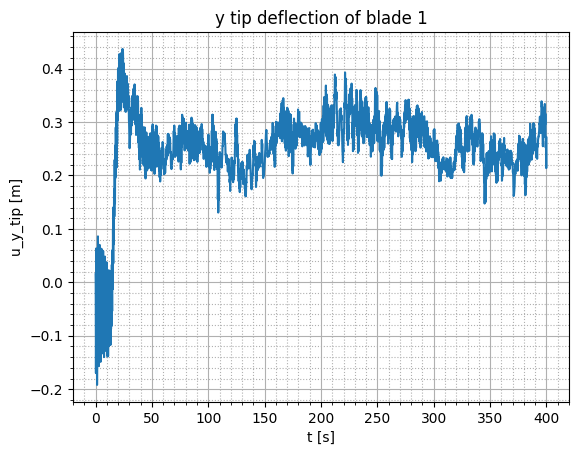

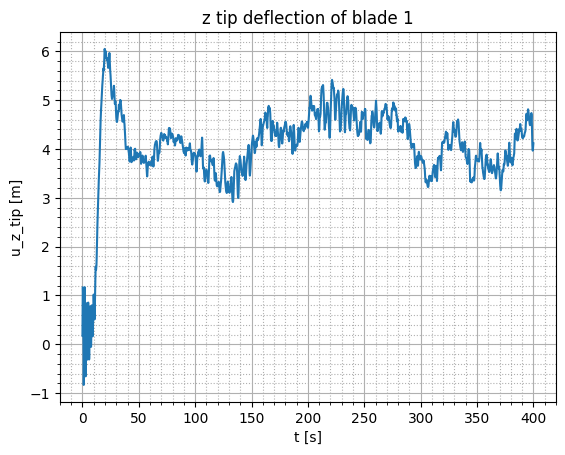

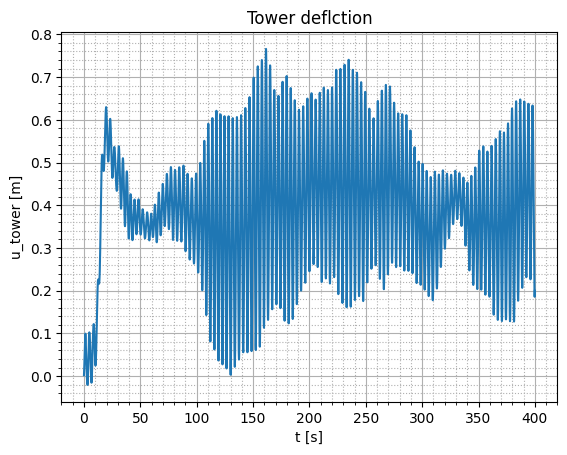

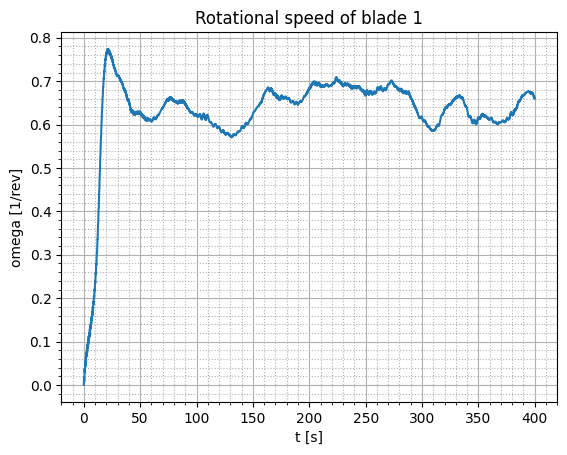

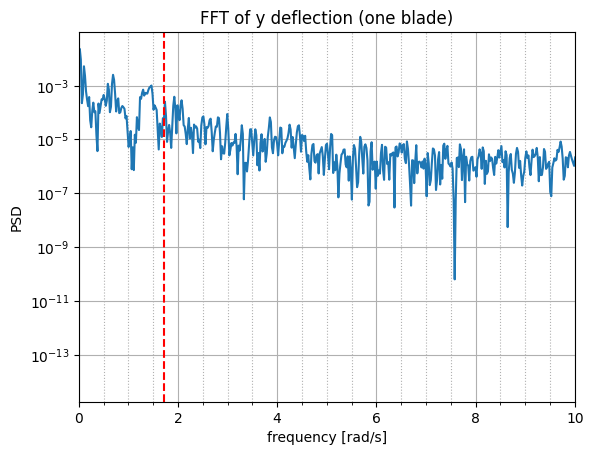

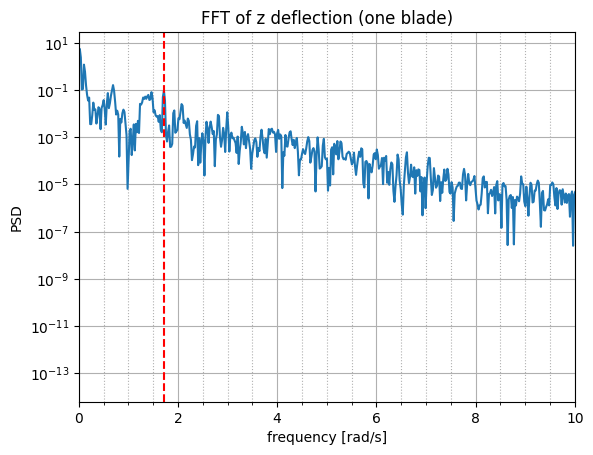

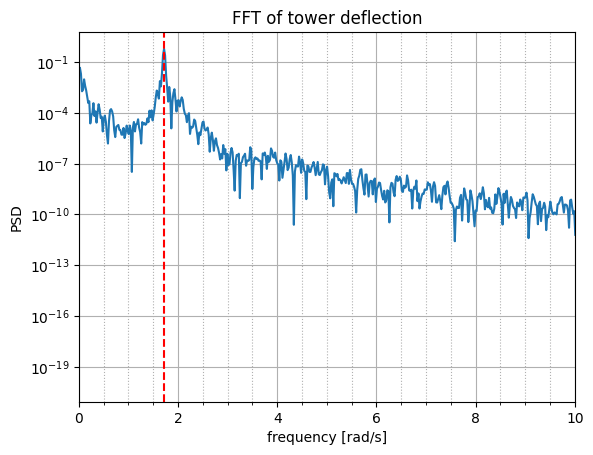

In [72]:
fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2['u_array'][:,0,-1,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_y_tip [m]')
ax.set_title('y tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2['u_array'][:,0,-1,1])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_z_tip [m]')
ax.set_title('z tip deflection of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uz_blade1_turb.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2['x_array'][:,0])
ax.set_xlabel('t [s]')
ax.set_ylabel('u_tower [m]')
ax.set_title('Tower deflction')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_uy_blade1.png", dpi=600)

fig, ax = plt.subplots()
ax.plot(solu_2['time'], solu_2["omega"])
ax.set_xlabel('t [s]')
ax.set_ylabel('omega [1/rev]')
ax.set_title('Rotational speed of blade 1')
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
fig.savefig("A3_Q1_omega_blade1.png", dpi=600)

f, Pxx_den = signal.welch(solu_2['u_array'][1000:,0,-1,0], fs = 2*np.pi/solu_2["dt"], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.semilogy(f, Pxx_den, "-")
ax.axvline(x=eigenomega[0], color='r', linestyle='--')
ax.set_xlabel('frequency [rad/s]')
ax.set_ylabel('PSD')
ax.set_title("FFT of y deflection (one blade)")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 10)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uy_FFT", dpi=600)

f, Pxx_den = signal.welch(solu_2['u_array'][1000:,0,-1,1], fs = 2*np.pi/solu_2["dt"], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.semilogy(f, Pxx_den, "-")
ax.axvline(x=eigenomega[0], color='r', linestyle='--')
ax.set_xlabel('frequency [rad/s]')
ax.set_ylabel('PSD')
ax.set_title("FFT of z deflection (one blade)")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 10)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uz_FFT", dpi=600)

f, Pxx_den = signal.welch(solu_2['x_array'][1000:,0], fs = 2*np.pi/solu_2["dt"], nperseg=1e6)
fig, ax = plt.subplots(1, 1)
ax.semilogy(f, Pxx_den, "-")
ax.axvline(x=eigenomega[0], color='r', linestyle='--')
ax.set_xlabel('frequency [rad/s]')
ax.set_ylabel('PSD')
ax.set_title("FFT of tower deflection")
ax.minorticks_on()
ax.grid(which='major', linestyle='-')  # Minor grid lines
ax.grid(which='minor', linestyle=':')  # Minor grid lines
ax.set_xlim(0, 10)
# ax.set_ylim(0,0.2e6)
fig.savefig("A3_Q1_uz_FFT", dpi=600)